# LEO cubesat motion and sensing simulation

CONFIDENTIAL

Author: Anthony Kalaydjian

The cells starting with % can be run by removing %

## Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
from math import *
import scipy
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import animation

## Simulation

### Constants

In [2]:
#satellite mass
m = 2.1234  #kg

#Inertial moment at center of mass
IGx = 0.0123 #kg*m^2
IGy = 0.0119 #kg*m^2
IGz = 0.0046 #kg*m^2

#distance between the geometric center and the mass centers
dOGx = 6.095e-4   #m
dOGy = 1.584e-3   #m
dOGz = 1.644e-3   #m

#Inertial moment at geometric center
Ix = IGx + m*dOGx**2 #kg*m^2
Iy = IGy + m*dOGy**2 #kg*m^2
Iz = IGz + m*dOGz**2 #kg*m^2

#solar flux constants
solar_constant = 1373 #W/m^2

#earth radius
r_earth = 6371000 #m

#atmospehre thickeness
d_atm = 80000           #m
r_atm = r_earth + d_atm #m

#earth rotation axis angle with orbit
alpha = 23.5*(pi/180)             #rad
earth_spin = 7.2921159e-5         #rad/s
orbit_rotation_rate = 1.991e-7    #rad/s

#earth magnetic field constants
mu0 = 4*pi*1e-7 #H/m
M = 8*10**22    #A*m^2

#stefan-boltzmann constant
sigma = 5.670374419e-8  #W/m^2 k^4

#EIR (Average infrared radiation emitted by Earth)
albedo_mean = 0.3
albedo_min = 0.14
albedo_max = 0.63

#angle of magnetic field axis with rotation angle
beta = 11*(pi/180)  #rad

#satellite orbit radius
altitude = 600000           #m
r_orb = altitude + r_earth  #m
period = 94.4*60            #s

#flux constants
Q_IR    = 239       #W/m^2
Q_solar = 1360.8    #W/m2

#flux emitted from 400nm to 1100nm
Q_0 = 907           #W/m^2

alpha_P = 0.01
alpha_OSR = 0.05
alpha_CNT = 0.07

sigma_P = alpha_P*Q_0           #W/m^2
sigma_OSR = alpha_OSR*Q_IR      #W/m^2
sigma_CNT = alpha_CNT*Q_solar   #W/m^2

#gyro model
sigma_u = 4.81e-05  #arc-s/s^(3/2)
sigma_v = 0.2       #arc-s/s^(1/2)

sigma_mag = 0.01*mu0*M/(2*pi*(r_orb**3))

In [3]:
Ix, Iy, Iz

(0.01230078882239685, 0.0119053277295104, 0.0046057389896223995)

### Quaternion operations

In [4]:
def q_to_R(q):
    """
    Returns the rotation matrix associated to the rotation defined by the quaternion
    """
    q = q.squeeze()
    try:
        q1 = q.iloc[0]
        q2 = q.iloc[1]
        q3 = q.iloc[2]
        q4 = q.iloc[3]
    except:
        try:
            q1 = q[0]
            q2 = q[1]
            q3 = q[2]
            q4 = q[3]
        except:
            q1 = q[0,0]
            q2 = q[0,1]
            q3 = q[0,2]
            q4 = q[0,3]
            
            

    R = np.matrix(
        [
            [1 - 2*(q2**2 + q3**2), 2*(q1*q2 - q3*q4), 2*(q1*q3 + q4*q2), 0],
            [2*(q1*q2 + q4*q3), 1 - 2*(q1**2 + q3**2), 2*(q2*q3 - q1*q4), 0],
            [2*(q1*q3 - q4*q2), 2*(q2*q3 + q4*q1), 1 - 2*(q1**2 + q2**2), 0],
            [0, 0, 0, 1]
        ]
    )

    return R.squeeze()

In [5]:
def R_to_q(R):
    """
    Computes the quaternion associated to a DCM
    """
    R = R.transpose()
    if (R[2,2] < 0):
        if R[0,0] >R[1,1]:
            t = 1 + R[0,0] -R[1,1] -R[2,2]
            q = np.matrix([t, R[0,1]+R[1,0], R[2,0]+R[0,2], R[1,2]-R[2,1]]).transpose()
        else:
            t = 1 -R[0,0] + R[1,1] -R[2,2]
            q = np.matrix([R[0,1]+R[1,0], t, R[1,2]+R[2,1], R[2,0]-R[0,2]]).transpose()

    else:
        if (R[0,0] < -R[1,1]):
            t = 1 -R[0,0] -R[1,1] + R[2,2]
            q = np.matrix([R[2,0]+R[0,2], R[1,2]+R[2,1], t, R[0,1]-R[1,0]]).transpose()

        else:
            t = 1 + R[0,0] + R[1,1] + R[2,2]
            q = np.matrix([R[1,2]-R[2,1], R[2,0]-R[0,2], R[0,1]-R[1,0], t]).transpose()

    q = q*0.5/sqrt(t)
    return q

In [6]:
"""Test R_to_q"""
u = np.random.random(3)
u = u/np.linalg.norm(u)
theta = np.random.random()
u = np.array([0,1,0]).transpose()
q = np.concatenate([sin(theta)*u, [cos(theta)]])

q_hat = np.array(R_to_q(q_to_R(q)).transpose()).squeeze()

print(q)
print(q_hat.squeeze())

[0.         0.65084792 0.         0.75920813]
[0.         0.65084792 0.         0.75920813]


### Frame transformation matrices

In [7]:
##P_I_ORB
def P_I_ORB_f(time):
    """just rotate of theta along the z axis"""
    theta = orbit_rotation_rate*time%(2*pi)
    v = np.array([0, 0, sin(theta/2)])
    q = np.concatenate((v, np.array([cos(theta/2)])), axis=0)
    P_I_ORB = q_to_R(q)[0:3, 0:3]
    
    return P_I_ORB

##P_I_ROT
def P_I_ROT_f(time):
    """Rotate the frame along its y axis then spin it along its new z axis"""
    P_I_RotAxis = q_to_R(np.array([0, sin(-alpha/2), 0, cos(-alpha/2)]))[0:3, 0:3]
    spin_angle = earth_spin*time%(2*pi)
    P_RotAxis_ROT = q_to_R(np.array([0, 0, sin(spin_angle/2), cos(spin_angle/2)]))[0:3, 0:3]
    P_I_ROT = P_I_RotAxis@P_RotAxis_ROT

    return P_I_ROT

#P_I_MAG
def P_I_MAG_f(time):
    """First calculate P_I_ROT, then rotate this frame of an angle of beta along its y axis"""
    P_I_ROT_ = P_I_ROT_f(time)
    P_ROT_MAG = q_to_R(np.array([0, sin(-beta/2), 0, cos(-beta/2)]))[0:3, 0:3]

    P_I_MAG = P_I_ROT_@P_ROT_MAG

    return P_I_MAG

#P_ORB_ROT
def P_ORB_ROT_f(time):
    P_I_ORB = P_I_ORB_f(time)
    P_I_ROT = P_I_ROT_f(time)

    P_ORB_ROT = np.transpose(P_I_ORB)@P_I_ROT

    return P_ORB_ROT

#P_ORB_MAG
def P_ORB_MAG_f(time):
    P_I_ORB = P_I_ORB_f(time)
    P_I_MAG = P_I_MAG_f(time)

    P_ORB_MAG = np.transpose(P_I_ORB)@P_I_MAG
    
    return P_ORB_MAG

### Dynamics

In [8]:
def rotation_matrix(w):
    """
    Rotation matrix of the quaternion associated to the w vector
    """
    R = np.matrix(
        [[0, -w[2], w[1], w[0]],
        [w[2], 0, -w[0], w[1]],
        [-w[1], w[0], 0, w[2]],
        [-w[0], -w[1], -w[2], 0]])
    return R

In [9]:
def dw_dt(w, t):
    """
    Returns the values of the w derivatives in Euler's formula when no torque is applied
    """
    dw1 = -((Iz-Iy)/Ix)*w[1]*w[2]
    dw2 = -((Ix-Iz)/Iy)*w[2]*w[0]
    dw3 = -((Iy-Ix)/Iz)*w[0]*w[1]

    return(dw1, dw2, dw3)

In [10]:
def q_sequence(q, w, n_iter, dt):
    """
    Returns, in the inertial frame, the sequence of attitude quaternion resulting from the rotation sequence w occuring in the body frame
    """
    q_list = []
    old_q = q
    for i in range(n_iter):
        new_q = old_q + (1/2)*dt*rotation_matrix(w[i])@old_q
        new_q = new_q/np.linalg.norm(new_q)
        q_list.append(new_q)
        old_q = new_q        

    return np.array(q_list)

In [11]:
def satellite_position(time, t0, initial_position):
    """
    Returns satellite's position in the orbital frame
    """
    satellite_angle = (2*pi)*((time - t0)%period)/period
    R = q_to_R(np.array([0, sin(satellite_angle/2), 0, cos(satellite_angle/2)]))[0:3, 0:3]
    satellite_pos = R@initial_position
    
    return satellite_pos

### Sensors

#### Magnetic field

In [12]:
def B_from_ORB(pos_ORB, t):
    """
    returns the magnetic field in cartesian coordinates in the magnetic frame
    """
    P_MAG_ORB = P_ORB_MAG_f(t).transpose()

    #position in the magnetic frame
    pos_MAG = P_MAG_ORB@pos_ORB
    r = np.linalg.norm(pos_MAG)
    x, y, z = pos_MAG[0,0], pos_MAG[1,0], pos_MAG[2,0]

    theta = acos(z/r)
    phi = atan2(y, x)

    B_r = mu0*M*cos(theta)/(2*pi*(r**3))
    B_theta = mu0*M*sin(theta)/(4*pi*(r**3))
    B_phi = 0

    e_r = np.matrix([sin(theta)*cos(phi), sin(theta)*sin(phi), cos(theta)]).transpose()
    e_theta = np.matrix([cos(theta)*cos(phi), cos(theta)*sin(phi), -sin(theta)]).transpose()
    e_phi = np.matrix([-sin(phi), cos(phi), 0]).transpose()

    #Calculate B in cartesian coordinates in the magnetic rotating frame
    B = B_r*e_r + B_theta*e_theta + B_phi*e_phi

    return B

In [13]:
def mag_df(row):
    """
    calculates the magnetic field in the satellite's body frame
    """
    #coordinates in the orbital frame
    x, y, z, t = row.x, row.y, row.z, row.t
    pos_ORB = np.matrix([x, y, z]).transpose()

    #magnetic field in the magnetic frame
    B = B_from_ORB(pos_ORB, t)

    #magnetic field in the inertial frame
    B_I = P_I_MAG_f(t)@B
    
    #magnetic field in the body frame
    P_I_SAT = q_to_R(np.matrix([row.q1, row.q2, row.q3, row.q4]).transpose())[0:3, 0:3]
    B_sat = P_I_SAT.transpose()@B_I
    return np.array(B_sat).squeeze()

In [14]:
def mag_BODY_to_I(row):
    """
    calculates the magnetic field vector direction in the inertial frame, at each step
    """
    B_BODY = np.matrix(row[['Bx', 'By', 'Bz']]).transpose()

    q = row[['q1', 'q2', 'q3', 'q4']].values
    P_I_BODY = q_to_R(q)[0:3,0:3]

    B_I = P_I_BODY@B_BODY

    return np.array(B_I).squeeze()

#### Light flux sensors

In [15]:
"""Albedo model"""
def theta_ORB_TO_ROT(r_M_ORB, time):
    """
    Returns the theta angle associated to the positon r_M_ORB as seen in the ROT frame
    """
    P_ROT_I = P_I_ROT_f(time).transpose()
    P_I_ORB = P_I_ORB_f(time)

    r_M_ROT = P_ROT_I@P_I_ORB@r_M_ORB
    
    x,y,z = r_M_ROT[0,0], r_M_ROT[1,0], r_M_ROT[2,0]

    r = sqrt(x**2 + y**2 + z**2)
    theta_ROT = acos(z/r)

    return theta_ROT

def albedo(r_M_ORB, time):
    """
    Computes the albedo at a given point on Earth's surface, at a given time
    """
    theta_ROT = theta_ORB_TO_ROT(r_M_ORB, time)
    
    if (theta_ROT==pi/2):
        return albedo_min
    
    alb_alpha = (albedo_max - albedo_min)/(albedo_max*np.exp(-4/pi**2))
    alb = albedo_min + alb_alpha*albedo_max*np.exp(-1/(theta_ROT-pi/2)**2)
    
    return alb

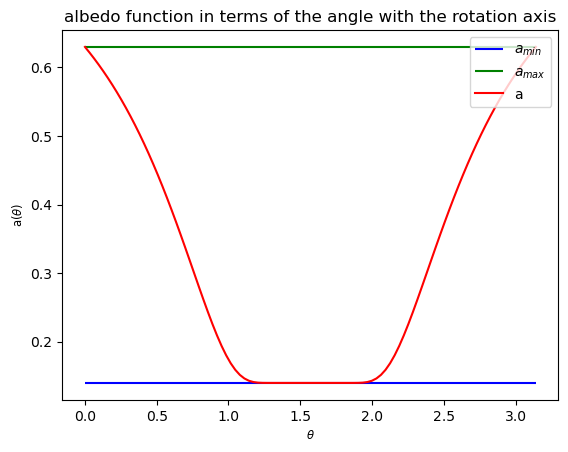

In [16]:
#plotting the albedo function in terms of theta in the ROT frame
%matplotlib inline
alb_alpha = (albedo_max - albedo_min)/(albedo_max*np.exp(-4/pi**2))
f = lambda theta: albedo_min + alb_alpha*albedo_max*np.exp(-1/(theta-pi/2)**2)
theta_list = np.linspace(0, pi, 100)

plt.hlines(y=albedo_min, xmin=0, xmax=pi, color="blue")
plt.hlines(y=albedo_max, xmin=0, xmax=pi, color="green")
plt.plot(theta_list, f(theta_list), color='red')

plt.title('albedo function in terms of the angle with the rotation axis')
plt.xlabel("$\\theta$", fontsize = 'small')
plt.ylabel("a($\\theta$)", fontsize = 'small')
plt.legend(("$a_{min}$", "$a_{max}$", "a"), loc="upper right")

$a(\theta) := a_{min} + \frac{a_{max} - a_{min}}{a_{max} e^{-4/\pi^2}} a_{max} e^{-\frac{1}{(\theta - \pi/2)^2}}$

In [17]:
def infinitesimal_view_factor_on_plate(theta, phi, row, n_p):
    """
    calculates the light flux contribution of an infinitesimal surface on Earth's atmosphere (taking albedo into account)
    on the satellite face defined by its normal n_p.
    All calculations are made in the orbital frame
    """
    time = row.t
    r_M = np.matrix([r_earth*sin(theta)*cos(phi), r_earth*sin(theta)*sin(phi), r_earth*cos(theta)]).transpose()
    r_P = np.matrix([row.x, row.y, row.z]).transpose()

    n_M = r_M/np.linalg.norm(r_M)
    PM = r_M - r_P
    r = np.linalg.norm(PM)
    s = np.matrix([1, 0, 0]).transpose()

    cos_i = ((-s.transpose())@n_M)[0,0]
    cos_M = (n_M.transpose()@(-PM/r))[0,0]
    cos_P = (n_p.transpose()@(PM/r))[0,0]

    if ((cos_i<=0) or (cos_P<=0) or (cos_M<=0)):
        dF = 0.0
    else:
        dF = albedo(r_M_ORB=r_M, time=time)*cos_i*cos_M*cos_P*sin(theta)*(r_atm**2)/(pi*r**2)

    return dF

def view_factor_on_plate(row, n_p):
    """
    Integrates the infinitesimal view factor on all of earth surface
    """
    theta_lower = 0
    theta_upper = pi
    phi_lower = pi/2
    phi_upper = 3*pi/2

    result, error = scipy.integrate.dblquad(lambda theta, phi: infinitesimal_view_factor_on_plate(theta, phi, row=row, n_p=n_p),
    phi_lower, phi_upper, theta_lower, theta_upper, epsabs=e-2)

    return result

def reflected_earth_view_factor(row):
    """
    returns the sun's flux that is reflected by earth on each face of the satellite
    """
    x, z = row.x, row.z
    if ((x>=0) and (abs(z)<=r_earth)):
        return np.zeros(shape=6)
    
    q = np.matrix([row.q1, row.q2, row.q3, row.q4]).transpose()
    
    P_I_BODY = q_to_R(q)[0:3, 0:3]
    P_ORB_I = P_I_ORB_f(row.t).transpose()
    
    #body frame vectors in the orbital reference frame
    u_x = P_ORB_I@P_I_BODY[:, 0]
    u_y = P_ORB_I@P_I_BODY[:, 1]
    u_z = P_ORB_I@P_I_BODY[:, 2]
    
    faces = [u_x, -u_x, u_y, -u_y, u_z, -u_z]
    F_list = np.zeros(len(faces))
    for i in range(len(faces)):
        F_list[i] = view_factor_on_plate(row, faces[i])
    
    return F_list

In [18]:
def incident_solar_flux_fraction(row):
    """
    returns the absorbed incident solar flux fraction on each face of the satellite
    """
    x, z = row.x, row.z
    if ((x>=0) and (abs(z)<=r_earth)):
        return np.zeros(shape=6)

    q = np.matrix([row.q1, row.q2, row.q3, row.q4]).transpose()
    
    P_I_BODY = q_to_R(q)[0:3,0:3]
    P_ORB_I = P_I_ORB_f(row.t).transpose()

    #body frame vector coordinates in the orbital frame
    u_x = P_ORB_I@P_I_BODY[:, 0]
    u_y = P_ORB_I@P_I_BODY[:, 1]
    u_z = P_ORB_I@P_I_BODY[:, 2]
    
    faces = np.array([u_x, -u_x, u_y, -u_y, u_z, -u_z])

    #sun vector, in the sun ray travelling direction, in the orbital frame
    s = np.matrix([1,0,0]).transpose()
    
    #flux calculation on each face
    fraction_list = np.zeros(shape=6)
    for i in range(len(faces)):
        cos_theta = (faces[i].transpose()@(-s))[0,0]
        fraction_list[i] = cos_theta if cos_theta>0 else 0
    
    return fraction_list

In [19]:
def black_body_view_factor(row):
    """
    returns the earth black body radiation view factor on each face of the satellite
    """
    #position of the satellite in the orbital frame
    pos_ORB = np.matrix([row.x, row.y, row.z]).transpose()
    n = pos_ORB/np.linalg.norm(pos_ORB)

    q = np.matrix([row.q1, row.q2, row.q3, row.q4]).transpose()
    
    P_I_BODY = q_to_R(q)[0:3, 0:3]
    P_ORB_I = P_I_ORB_f(row.t).transpose()

    #body frame vector coordinates in the orbital frame
    u_x = P_ORB_I@P_I_BODY[:, 0]
    u_y = P_ORB_I@P_I_BODY[:, 1]
    u_z = P_ORB_I@P_I_BODY[:, 2]
    
    faces = [u_x, -u_x, u_y, -u_y, u_z, -u_z]

    F_list = np.zeros(shape=6)

    h = r_orb
    H = h/r_earth
    phi = asin(1/H)

    for i in range(len(faces)):
        lbda = acos((-n.transpose()@faces[i])[0,0])
        if (lbda < pi/2 - phi):
            F = cos(lbda)/H**2
        elif (lbda <= pi/2 + phi):
            F = 1/2 - (1/pi)*asin(sqrt(H**2-1)/(H*sin(lbda))) + (1/(pi*H**2))*(cos(lbda)*acos(-sqrt(H**2-1)*cos(lbda)/sin(lbda)) - sqrt(H**2-1)*sqrt(1 - H**2*cos(lbda)**2))
        else:
            F = 0
        F_list[i] = F

    return F_list

#### Others

In [20]:
def gyro_noise(df, dt):
    """
    Simulates the gyroscope's noise
    """
    gyro = np.zeros_like(df[["w_x", "w_y", "w_z"]])

    old_beta = 0

    for i in range(len(df)):
        w = df.iloc[i][["w_x", "w_y", "w_z"]]

        N_u = np.random.normal(loc=0, scale=1, size=3)
        N_v = np.random.normal(loc=0, scale=1, size=3)

        new_beta = old_beta + sigma_u*(dt**(1/2))*N_u

        gyro[i,:] = w + (1/2)*(new_beta + old_beta) + sqrt((sigma_v**2)/dt + (1/12)*(sigma_u**2)*dt)*N_v
        old_beta = new_beta
    
    return gyro

In [21]:
def sun_LOS_df(row):
    """
    Returns the Sun Line of Site, in the inertial frame
    """
    s_ORB = np.matrix([-1, 0, 0]).transpose()

    P_I_ORB = P_I_ORB_f(row.t)

    s_I = P_I_ORB@s_ORB

    return np.array(s_I).squeeze()

In [22]:
def nadir_df(row):
    """
    Returns the nadir direction in the inertial frame
    """
    r_ORB = np.matrix(row[["x", "y", "z"]]).transpose()

    P_I_ORB = P_I_ORB_f(row.t)

    r_I = P_I_ORB@r_ORB

    nadir = -r_I/np.linalg.norm(r_I)

    return(np.array(nadir).squeeze())

### All-in-one dataframe generating function

In [23]:
def generate_df(t0, dt, n_iter, w0, initial_q, initial_angle, sigma_OSR=sigma_OSR, sigma_P=sigma_P, sigma_CNT=sigma_CNT):
    """
    Generates a dataframe given the initial conditions
    """
    
    #time at each time step
    t_list = t0 + np.arange(start=0, stop=n_iter*dt, step=dt)

    #w is the angular at each time step in the satellite's body frame
    w = odeint(dw_dt, w0, t_list)

    #sequence of attitude quaternions
    q_list = q_sequence(q=initial_q, w=w, n_iter=n_iter, dt=dt)

    #initial position in the orbital frame
    R_init_0 = q_to_R(np.array([0, sin(initial_angle/2), 0, cos(initial_angle/2)]))[0:3, 0:3]
    initial_position = R_init_0@np.matrix([r_orb, 0, 0]).transpose()

    #sequence of positions in the orbital frame
    position_list = []
    for i in range(n_iter):
        position_list.append(satellite_position(t_list[i], t0, initial_position))
    
    df = pd.DataFrame(t_list, columns=["t"])
    df = pd.concat([df, pd.DataFrame(np.array(position_list).squeeze(), columns=["x", "y", "z"])], axis=1)
    df = pd.concat([df, pd.DataFrame(q_list.squeeze(), columns=["q1", "q2", "q3", "q4"])], axis=1)
    
    #include magnetic field measurements in the satellite's body frame
    df[['Bx', 'By', 'Bz']] = df.apply(mag_df, axis='columns', result_type='expand')
    #adding magnetometer error
    df[['mag_x', 'mag_y', 'mag_z']] = df[['Bx', 'By', 'Bz']] + np.random.normal(loc=0, scale=sigma_mag, size=(n_iter,3))

    #True magnetic field in the inertial frame
    df[['B_I_x', 'B_I_y', 'B_I_z']] = df.apply(mag_BODY_to_I, axis='columns', result_type='expand')

    #Sun Line of sight in inertial frame
    df[['s_I_x', 's_I_y', 's_I_z']] = df.apply(sun_LOS_df, axis='columns', result_type='expand')

    #nadir direction in inertial frame
    df[['n_I_x', 'n_I_y', 'n_I_z']] = df.apply(nadir_df, axis='columns', result_type='expand')

    #include light sensors measurements on each face of the satellite
    incident_sun_flux_fraction = df.apply(incident_solar_flux_fraction, axis='columns', result_type='expand')
    reflected_view_factor = df.progress_apply(reflected_earth_view_factor, axis='columns', result_type='expand')
    bb_view_factor = df.apply(black_body_view_factor, axis='columns', result_type='expand')

    sun_flux_fraction = incident_sun_flux_fraction + reflected_view_factor

    df[['CNT_px', 'CNT_mx', 'CNT_py', 'CNT_my', 'CNT_pz', 'CNT_mz']] = Q_solar*sun_flux_fraction + Q_IR*bb_view_factor + np.random.normal(loc=0, scale=sigma_CNT, size=(n_iter,6))
    df[['OSR_px', 'OSR_mx', 'OSR_py', 'OSR_my', 'OSR_pz', 'OSR_mz']] = 0.06*Q_solar*sun_flux_fraction + 0.84*Q_IR*bb_view_factor + np.random.normal(loc=0, scale=sigma_OSR, size=(n_iter,6))
    df[['P_px', 'P_mx', 'P_py', 'P_my', 'P_pz', 'P_mz']] = Q_0*sun_flux_fraction + np.random.normal(loc=0, scale=sigma_P, size=(n_iter,6))
    
    #removing negative values that may appear when the light flux is small compared to the gaussian noise
    df[['OSR_px', 'OSR_mx', 'OSR_py', 'OSR_my', 'OSR_pz', 'OSR_mz']] = np.abs(df[['OSR_px', 'OSR_mx', 'OSR_py', 'OSR_my', 'OSR_pz', 'OSR_mz']])
    df[['CNT_px', 'CNT_mx', 'CNT_py', 'CNT_my', 'CNT_pz', 'CNT_mz']] = np.abs(df[['CNT_px', 'CNT_mx', 'CNT_py', 'CNT_my', 'CNT_pz', 'CNT_mz']])
    df[['P_px', 'P_mx', 'P_py', 'P_my', 'P_pz', 'P_mz']] = np.abs(df[['P_px', 'P_mx', 'P_py', 'P_my', 'P_pz', 'P_mz']])

    #real rotation rate in the body frame
    df[['w_x', 'w_y', 'w_z']] = w

    #add noise to the gyro noise
    df[['gyro_x', 'gyro_y', 'gyro_z']] = w + gyro_noise(df, dt)

    return(df)

### Results

#### Single dataframe generation

In [24]:
"""simulation constants"""
"""sigma_P = 0
sigma_OSR = 0
sigma_CNT = 0
sigma_mag = 0"""
%
#t0 = 365*86400//3  #s
t0 = np.random.randint(0, 365*86400)
#t0 = 0
dt = 1  #s
n_iter = 600
w0 = 0.15*np.random.random(size=3)  #rad/s

rotation_axis = np.matrix(np.random.random(size=3)).transpose()
rotation_axis = rotation_axis/np.linalg.norm(rotation_axis)
initial_rotation_angle = 2*pi*np.random.random()
initial_q = np.concatenate([sin(initial_rotation_angle/2)*rotation_axis, np.matrix([cos(initial_rotation_angle/2)])], axis=0)

initial_angle = pi - pi/8 #rad
initial_angle = 0

df = generate_df(t0, dt, n_iter, w0, initial_q, initial_angle)

fname = "datasets/new_test.csv"
df.to_csv(fname)

UsageError: Line magic function `%` not found.


##### Save df

In [25]:
%
fname = "datasets/" + "no_error_" + "df1_t0=" + str(t0) + "_n=" + str(n_iter) + "_dt=" + str(dt) + "_w0=" + str(w0) + "initial_angle=" + str(initial_angle) + ".csv"
df.to_csv(fname)

UsageError: Line magic function `%` not found.


#### Shadow zone multiple generation

In [80]:
N_theta = 10
N_phi   = 10
N_time  = 10
N_angle = 10
N_train = N_theta*N_phi*N_time*N_angle
n_iter = 60
counter = 0
dt = 1

In [26]:
%
%%capture
"""Generating data in the shadow zone"""
np.random.seed(42)

dirname = "datasets/train_sets"
try:
    os.makedirs(dirname)
except:
    pass

for i in range(N_theta):
    for j in range(N_phi):
        for k in range(N_time):
            for l in range(N_angle):
                initial_angle = (l/N_angle)*2*np.pi

                theta   = (i/N_theta)*np.pi
                phi     = (j/N_phi)*2*np.pi
                t0      = (k/N_time)*(365*86400)

                initial_axis = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])

                initial_q = np.matrix([sin(initial_angle/2)*initial_axis[0], sin(initial_angle/2)*initial_axis[1],
                                      sin(initial_angle/2)*initial_axis[2], cos(initial_angle/2)]).transpose()
                
                w0 = 0.15*np.random.random(size=3)  #rad/s

                initial_position_angle = 0
                
                df = generate_df(t0, dt, n_iter, w0, initial_q, initial_position_angle)

                fname = dirname + "/df_" + str(counter) + ".csv" 
                df.to_csv(fname)

                counter += 1


#Create test and validation sets
np.random.seed(42)

N_val   = int(0.2*N_train)
N_test  = int(0.2*N_train)

try:
    os.makedirs("datasets/test_sets")
except:
    pass

for i in range(N_test):
    initial_angle = np.random.random()*2*np.pi
    theta   = np.random.random()*np.pi
    phi     = np.random.random()*2*np.pi
    t0      = np.random.random()*(365*86400)

    initial_axis = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])

    initial_q = np.matrix([sin(initial_angle/2)*initial_axis[0], sin(initial_angle/2)*initial_axis[1],
                                      sin(initial_angle/2)*initial_axis[2], cos(initial_angle/2)]).transpose()
                
    w0 = 0.15*np.random.random(size=3)  #rad/s

    initial_position_angle = 0
                
    df = generate_df(t0, dt, n_iter, w0, initial_q, initial_position_angle)

    fname = "datasets/test_sets/df_" + str(i) + ".csv" 
    df.to_csv(fname)


try:
    os.makedirs("datasets/val_sets")
except:
    pass

for i in range(N_val):
    initial_angle = np.random.random()*2*np.pi
    theta   = np.random.random()*np.pi
    phi     = np.random.random()*2*np.pi
    t0      = np.random.random()*(365*86400)

    initial_axis = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])

    initial_q = np.matrix([sin(initial_angle/2)*initial_axis[0], sin(initial_angle/2)*initial_axis[1],
                                      sin(initial_angle/2)*initial_axis[2], cos(initial_angle/2)]).transpose()
                
    w0 = 0.15*np.random.random(size=3)  #rad/s

    initial_position_angle = 0
                
    df = generate_df(t0, dt, n_iter, w0, initial_q, initial_position_angle)

    fname = "datasets/val_sets/df_" + str(i) + ".csv" 
    df.to_csv(fname)


"""creating the test/train/val datasets and saving them"""
path = r"./datasets/" + "/study_datasets"
try:
    os.makedirs(path)
except:
    pass

np.random.seed(36)

version = "train_sets"
N_train = 10000
N_test = int(0.2*N_train)
N_val = int(0.2*N_train)

df_train    = pd.DataFrame()
df_test     = pd.DataFrame()
df_val      = pd.DataFrame()

for i in range(N_train):
    fname = "datasets/train_sets/df_" + str(i) + ".csv"
    df_train = pd.concat([df_train, pd.read_csv(fname)], axis=0)
df_train.to_csv("datasets/study_datasets/train.csv")

for i in range(N_test):
    fname = "datasets/test_sets/df_" + str(i) + ".csv"
    df_test = pd.concat([df_test, pd.read_csv(fname)], axis=0)
df_test.to_csv("datasets/study_datasets/test.csv")

for i in range(N_val):
    fname = "datasets/val_sets/df_" + str(i) + ".csv"
    df_val = pd.concat([df_val, pd.read_csv(fname)], axis=0)
df_val.to_csv("datasets/study_datasets/val.csv")

df_train.shape, df_test.shape, df_val.shape

UsageError: Line magic function `%` not found.


#### Multiple dataframe generation

In [27]:
def data_generation(N_df = 10, n_iter=600, dt=1, version=0):
    path = r"./datasets/v" + str(version)
    try:
        os.makedirs(path)
    except:
        pass
    info = ["N_df=" + str(N_df) + " n_iter=" + str(n_iter) + " dt=" + str(dt)]

    for i in range(N_df):
        initial_angle = 2*pi*i/N_df  #rad
        t0 = np.random.randint(0, 365*86400) #s

        rotation_axis = np.matrix(np.random.random(size=3)).transpose()
        rotation_axis = rotation_axis/np.linalg.norm(rotation_axis)
        initial_rotation_angle = 2*pi*np.random.random()
        initial_q = np.concatenate([sin(initial_rotation_angle/2)*rotation_axis, np.matrix([cos(initial_rotation_angle/2)])], axis=0)

        #maximum initial rotation rate of 0.15 rad/s ~ 8.6 deg/s
        w0 = 0.15*np.random.random(size=3)

        df = generate_df(t0, dt, n_iter, w0, initial_q, initial_angle)

        fname = "datasets/" + "v" + str(version) + "/" + "v" + str(version) + "_" + "df" + str(i) + ".csv"
        df.to_csv(fname)

        info.append(fname + " : initial_angle=" + str(initial_angle) + " t0=" + str(t0) 
                    + " rotation_axis=" + str(np.array(rotation_axis.transpose()).squeeze()) + " initial_rotation_angle=" + str(initial_rotation_angle) 
                    + " initial_q=" + str(np.array(initial_q.transpose()).squeeze()) + " : w0=" + str(w0))

    with open("datasets/v" + str(version) + "/" + "v" + str(version) + "_info.txt", 'w') as fp:
        for item in info:
            #write each item on a new line
            fp.write("%s\n" % item)

    return 0

In [28]:
"""Generation of multiple datasets"""
#1000 datasets of 60 seconds worth of data each
%
data_generation(N_df = 1000, n_iter=60, dt=1, version=5)

UsageError: Line magic function `%` not found.


#### plot

In [29]:
'''earth sphere surface plot'''
N = 50
phi = np.linspace(0, 2 * np.pi, N)
theta = np.linspace(0, np.pi, N)
theta, phi = np.meshgrid(theta, phi)

r = r_earth
X_Earth = r * np.cos(phi) * np.sin(theta)
Y_Earth = r * np.sin(phi) * np.sin(theta)
Z_Earth = r * np.cos(theta)

In [30]:
def animate_data_frame(step, df, B_ORB, F_BODY, lim=2, sat_center=False, draw_earth=False):
    #graphics
    ax.clear()

    #draw earth
    if (draw_earth):
        ax.plot_surface(X_Earth, Y_Earth, Z_Earth, color='blue', alpha=0.7)

    if (not sat_center):
        ax.set_xlim3d(-lim, lim)
        ax.set_ylim3d(-lim, lim)
        ax.set_zlim3d(-lim, lim)
    else:
        lim = 2
        scale = 1
        ax.set_xlim3d(x - lim, x + lim)
        ax.set_ylim3d(y - lim, y + lim)
        ax.set_zlim3d(z - lim, z + lim)

    #read data
    t = df.iloc[step]['t']

    q = np.matrix([df.iloc[step]['q1'], df.iloc[step]['q2'], df.iloc[step]['q3'], df.iloc[step]['q4']]).transpose()

    x = df.iloc[step]['x']
    y = df.iloc[step]['y']
    z = df.iloc[step]['z']

    #elapsed time
    year = int(t//(365*86400))
    day = int((t%(365*86400))//(86400))
    hour = int((t%(86400))//(3600))
    minute = int((t%3600)//60)
    second = int(t%60)

    ax.set_title('time = ' + str(year) + "y " + str(day) + "d " + str(hour) + "h " + str(minute) + "min " + str(second) + "s ")
    #ax.set_title('time = ' + str(round(step*dt, 2)) + "s")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    scale = lim/5

    #draw satellite's body frame
    #sat_frame_update(step, dt, x, y, z, scale=scale)
    P_I_body = q_to_R(q)[0:3, 0:3]

    P_ORB_I = P_I_ORB_f(t).transpose()

    u = scale*P_ORB_I*P_I_body[:, 0]
    v = scale*P_ORB_I*P_I_body[:, 1]
    w = scale*P_ORB_I*P_I_body[:, 2]

    ax.quiver(x, y, z, u[0], u[1], u[2], color="blue")
    ax.quiver(x, y, z, v[0], v[1], v[2], color="blue")
    ax.quiver(x, y, z, w[0], w[1], w[2], color="purple")

    #draw the magnetic field vector
    mag = B_ORB[step]
    ax.quiver(x,y,z, scale*mag[0], scale*mag[1], scale*mag[2], color="red")

    #draw the nadir direction
    n_I_x, n_I_y, n_I_z = df.iloc[step][["n_I_x", "n_I_y", "n_I_z"]]
    n_ORB = P_ORB_I*np.matrix([n_I_x, n_I_y, n_I_z]).transpose()
    n_ORB = scale*n_ORB/np.linalg.norm(n_ORB)
    ax.quiver(x, y, z, n_ORB[0], n_ORB[1], n_ORB[2], color="black")

    #draw the sun LOS
    s_I_x, s_I_y, s_I_z = df.iloc[step][["s_I_x", "s_I_y", "s_I_z"]]
    s_ORB = scale*P_ORB_I*np.matrix([s_I_x, s_I_y, s_I_z]).transpose()
    ax.quiver(x, y, z, s_ORB[0], s_ORB[1], s_ORB[2], color="yellow")
    
    #draw magnetic moment
    m = P_ORB_MAG_f(time=t)[0:3, 2]
    m = m/np.linalg.norm(m)
    mag_scale = r_earth
    #ax.quiver(-mag_scale*m[0], -mag_scale*m[1], -mag_scale*m[2], mag_scale*m[0], mag_scale*m[1], mag_scale*m[2], length=2*mag_scale, color="black")
    ax.quiver(-mag_scale*m[0], -mag_scale*m[1], -mag_scale*m[2], m[0], m[1], m[2], length=2*mag_scale, color="black")

    #draw photodiode sensor measurement normalized vector
    for i in range(6):
        v_body = np.matrix(F_BODY[step, :, i]).transpose()
        v_ORB  = P_I_ORB_f(time=t).transpose()@P_I_body@v_body
        ax.quiver(x, y, z, 5*scale*v_ORB[0], 5*scale*v_ORB[1],5*scale*v_ORB[2], color="green", linewidth=2)
    
    #draw satellite center
    ax.scatter3D(x, y, z, c="black")

In [31]:
def B_ORB_f(df):
    """
    calculates the magnetic field vector direction in the orbital frame, at each step, sensed by the magnetometer measurements
    """
    B = df.apply(lambda row: 
                row[['mag_x', 'mag_y', 'mag_z']]/np.linalg.norm(row[['mag_x', 'mag_y', 'mag_z']]),
                axis=1).values
    B_ORB = np.zeros(B.shape)

    q_values = df[['q1', 'q2', 'q3', 'q4']].values
    time = df['t'].values
    for i in range(len(df)):
        q = q_values[i]
        t = time[i]
        P = P_I_ORB_f(time=t)
        b = B[i]
        B_ORB[i] = P.transpose()@q_to_R(q)[0:3, 0:3]@b
    
    return B_ORB

def F_BODY_f(df, light_sensor):
    """
    calculates the normalized light flux on each of the satellite's faces at each step
    """
    F = df.apply(lambda row: 
                row[[light_sensor + '_px', light_sensor + '_mx', light_sensor + '_py', light_sensor + '_my', light_sensor + '_pz', light_sensor + '_mz']]/np.linalg.norm(row[[light_sensor + '_px', light_sensor + '_mx', light_sensor + '_py', light_sensor + '_my', light_sensor + '_pz', light_sensor + '_mz']]),
                axis=1).values
    F = np.nan_to_num(F)
    #F_df = pd.DataFrame(F, columns=['CNT_px', 'CNT_mx', 'CNT_py', 'CNT_my', 'CNT_pz', 'CNT_mz'])

    F_BODY = np.zeros(shape=(len(F), 3, 6))
    for i in range(len(F)):
        f = F[i]

        F_BODY[i][0,0] =  f[0]
        F_BODY[i][0,1] = -f[1]
        F_BODY[i][1,2] =  f[2]
        F_BODY[i][1,3] = -f[3]
        F_BODY[i][2,4] =  f[4]
        F_BODY[i][2,5] = -f[5]

    return F_BODY

##### read df

In [32]:
fname = "datasets\df1_t0=5256000_n=30_dt=1_w0=[0, 0.1, 0.1]initial_angle=3.141592653589793.csv"
df = pd.read_csv(fname)

##### Draw

In [33]:
"""Draw sensors"""
B_ORB = B_ORB_f(df)

#Choose between CNT, P and OSR sensors
F_BODY = F_BODY_f(df, light_sensor="P")

Here is an example of the generated data. The blue arrows represent the frame attached to the satellite's body. The red arrow points towards the magnetic moment of Earth while the yellow points towards the Sun. The green arrows represent the different fluxes received on each face of the satellite (they are normalized).

In [34]:
%matplotlib qt
fig = plt.figure()
ax = plt.axes(projection='3d')
anim = animation.FuncAnimation(fig, lambda step: animate_data_frame(step, df, B_ORB, F_BODY, lim=7000000, draw_earth=True), interval=10, frames=len(df))
plt.show()

##### Save animation

In [35]:
#Saving the Animation as gif
%
f = r"videos/animation.gif"
writergif = animation.PillowWriter(fps=int(1/dt))
anim.save(f, writer=writergif)

UsageError: Line magic function `%` not found.


In [36]:
#Saving the Animation as mp4
%
import matplotlib as mpl 
mpl.rcParams['animation.ffmpeg_path'] = r'C:/ProgramData/ffmpeg/bin/ffmpeg.exe'

f = r"videos/animation.mp4" 
writervideo = animation.FFMpegWriter(fps=10) 
anim.save(f, writer=writervideo)

UsageError: Line magic function `%` not found.


## Attitude estimation

### Triad method

In [37]:
"""Uses Triad method to estimate the attitude of the satellite"""
def vector_direction(row, vector, threshold=1.5):
    """
    Returns the estimated normalized vector's direction in the body frame of reference
    """
    ux = np.matrix([1,0,0]).transpose()
    uy = np.matrix([0,1,0]).transpose()
    uz = np.matrix([0,0,1]).transpose()

    vector_list = [ux, uy, uz]

    if (vector=="sun"):
        sensor="P"
    elif (vector=="nadir"):
        sensor="OSR"
    else:
        print("error")
        return 1
    
    P = row[[sensor + "_px", sensor + "_py", sensor + "_pz"]]
    M = row[[sensor + "_mx", sensor + "_my", sensor + "_mz"]]

    vector_direction = np.matrix([0,0,0]).transpose()
    for i in range(len(P)):
        if P.iloc[i] > threshold*M.iloc[i]:
            vector_direction = vector_direction + P.iloc[i]*vector_list[i]
        elif M.iloc[i] > threshold*P.iloc[i]:
            vector_direction = vector_direction - M.iloc[i]*vector_list[i]
        else:
            vector_direction = vector_direction + (P.iloc[i] - M.iloc[i])*vector_list[i]
    
    vector_direction = vector_direction/np.linalg.norm(vector_direction)

    return vector_direction


def triad(row, threshold=1.5, sigma_u=sigma_u, sigma_v=sigma_v):
    """
    Returns the estimated attitude, computed using the sensor measurements 
    """
    x,y,z = row.x, row.y, row.z

    P_I_ORB = P_I_ORB_f(row.t)

    if (x>=0 and (abs(z)<=r_earth)):
        vector_BODY = vector_direction(row, vector="nadir", threshold=threshold)
        #vector_I = -r_I/np.linalg.norm(r_I)
        vector_I = np.matrix(row[["n_I_x", "n_I_y", "n_I_z"]]).transpose()
    else:
        vector_BODY = vector_direction(row, vector="sun", threshold=threshold)
        #vector_I = P_I_ORB@np.matrix([-1,0,0]).transpose()
        vector_I = np.matrix(row[["s_I_x", "s_I_y", "s_I_z"]]).transpose()
    
    mag_BODY = np.matrix(row[["mag_x", "mag_y", "mag_z"]]).transpose()
    mag_I = np.matrix(row[["B_I_x", "B_I_y", "B_I_z"]]).transpose()

    #normalization
    mag_BODY = mag_BODY/np.linalg.norm(mag_BODY)
    mag_I = mag_I/np.linalg.norm(mag_I)

    #Triad algorithm, starting with sun/nadir vector
    t_1_I = vector_I
    t_2_I = np.cross(vector_I, mag_I, axis=0)/np.linalg.norm(np.cross(vector_I, mag_I, axis=0))
    t_3_I = np.cross(t_1_I, t_2_I, axis=0)

    t_1_B = vector_BODY
    t_2_B = np.cross(vector_BODY, mag_BODY, axis=0)/np.linalg.norm(np.cross(vector_BODY, mag_BODY, axis=0))
    t_3_B = np.cross(t_1_B, t_2_B, axis=0)

    P_I_TRIAD_1 = np.concatenate([t_1_I, t_2_I, t_3_I], axis=1)
    P_BODY_TRIAD_1 = np.concatenate([t_1_B, t_2_B, t_3_B], axis=1)
    P_I_BODY_1 = P_I_TRIAD_1@P_BODY_TRIAD_1.transpose()
    
    #Triad algorithm, starting with magnetic vector
    t_1_I_m = mag_I
    t_2_I_m = np.cross(mag_I, vector_I, axis=0)/np.linalg.norm(np.cross(mag_I, vector_I, axis=0))
    t_3_I_m = np.cross(t_1_I_m, t_2_I_m, axis=0)

    t_1_B_m = mag_BODY
    t_2_B_m = np.cross(mag_BODY, vector_BODY, axis=0)/np.linalg.norm(np.cross(mag_BODY, vector_BODY, axis=0))
    t_3_B_m = np.cross(t_1_B_m, t_2_B_m, axis=0)

    P_I_TRIAD_m = np.concatenate([t_1_I_m, t_2_I_m, t_3_I_m], axis=1)
    P_BODY_TRIAD_m = np.concatenate([t_1_B_m, t_2_B_m, t_3_B_m], axis=1)
    P_I_BODY_m = P_I_TRIAD_m@P_BODY_TRIAD_m.transpose()

    #Fusion of the two results
    sigma_1 = 1
    sigma_m = 5

    A_star = (sigma_1**2/(sigma_1**2 + sigma_m**2))*P_I_BODY_1 + (sigma_m**2/(sigma_1**2 + sigma_m**2))*P_I_BODY_m
    estimated_attitude = (1/2)*(A_star + np.linalg.inv(A_star).transpose())

    return estimated_attitude

In [38]:
def mean_angle_error(q_df):
    """
    Computes the mean angle error for a dataframe containing the real quaternion q and
    q_hat, an estimation of q
    """
    error_sum  = 0
    for i in range(len(q_df)):
        q_hat   = np.matrix(q_df.loc[i][['q_hat1', 'q_hat2', 'q_hat3', 'q_hat4']]).transpose()
        q       = np.matrix(q_df.loc[i][['q1', 'q2', 'q3', 'q4']]).transpose()
        R_hat = q_to_R(q_hat)[0:3,0:3]
        R = q_to_R(q)[0:3,0:3]

        #R_hat = triad(row, threshold)

        barBB = R_hat.transpose()@R
        #print(barBB)
        error_phi = acos(0.5*(np.trace(barBB) - 1))*180/pi
        error_sum += error_phi
    return(error_sum/len(q_df))

def mean_triad_angle_error(df):
    """
    Returns the mean angle error for a dataframe for the quaternion estimated with
    the TRIAD method
    """
    q_df = pd.DataFrame(columns = ['q1', 'q2', 'q3', 'q4', 'q_hat1', 'q_hat2', 'q_hat3', 'q_hat4'])
    threshold = 1.5
    for i in range(len(df)):
        row = df.iloc[i]
        q_hat = np.array(R_to_q(triad(row, threshold, sigma_u, sigma_v)).transpose()).squeeze()
        q_hat = q_hat/np.linalg.norm(q_hat)
        q = np.array([row.q1, row.q2, row.q3, row.q4])

        q_df.loc[i] = np.concatenate([q, q_hat], axis=0)

    return(mean_angle_error(q_df))

def angle_error_std(q_df):
    """
    Computes the std angle error for a dataframe containing the real quaternion q and
    q_hat, an estimation of q
    """
    error_list = np.zeros(len(q_df))
    for i in range(len(q_df)):
        q_hat   = np.matrix(q_df.loc[i][['q_hat1', 'q_hat2', 'q_hat3', 'q_hat4']]).transpose()
        q       = np.matrix(q_df.loc[i][['q1', 'q2', 'q3', 'q4']]).transpose()
        R_hat = q_to_R(q_hat)[0:3,0:3]
        R = q_to_R(q)[0:3,0:3]

        #R_hat = triad(row, threshold)

        barBB = R_hat.transpose()@R
        #print(barBB)
        error_phi = acos(0.5*(np.trace(barBB) - 1))*180/pi
        error_list[i] = error_phi
    return(np.std(error_list))

def triad_angle_error_std(df):
    """
    Returns the std angle error for a dataframe for the quaternion estimated with
    the TRIAD method
    """
    q_df = pd.DataFrame(columns = ['q1', 'q2', 'q3', 'q4', 'q_hat1', 'q_hat2', 'q_hat3', 'q_hat4'])
    threshold = 1.5
    for i in range(len(df)):
        row = df.iloc[i]
        q_hat = np.array(R_to_q(triad(row, threshold, sigma_u, sigma_v)).transpose()).squeeze()
        q_hat = q_hat/np.linalg.norm(q_hat)
        q = np.array([row.q1, row.q2, row.q3, row.q4])

        q_df.loc[i] = np.concatenate([q, q_hat], axis=0)

    return(angle_error_std(q_df))

### MLP

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tqdm
import copy

In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
if torch.cuda.is_available(): print(f"Cuda device: {torch.cuda.get_device_name(torch.cuda.current_device())}")

Using cuda device
Cuda device: NVIDIA GeForce RTX 4070


In [88]:
"""reading the datasets"""
df_train_raw    = pd.read_csv("datasets/study_datasets/train.csv")
df_test_raw     = pd.read_csv("datasets/study_datasets/test.csv")
df_val_raw      = pd.read_csv("datasets/study_datasets/val.csv")

df_train_raw.shape, df_test_raw.shape, df_val_raw.shape

((600000, 49), (120000, 49), (120000, 49))

In [89]:
#df_train = df_train_raw.iloc[0:200000, :]
df_train = df_train_raw
df_test  = df_test_raw
df_val   = df_val_raw

In [90]:
"""Defining the input features and the output"""
X_columns = ['x', 'z', 'mag_x', 'mag_y', 'mag_z', 'B_I_x', 'B_I_y', 'B_I_z',
             's_I_x', 's_I_y', 'n_I_x', 'n_I_y', 'n_I_z', 'CNT_px', 'CNT_mx', 'CNT_py',
             'CNT_my', 'CNT_pz', 'CNT_mz', 'OSR_px', 'OSR_mx', 'OSR_py', 'OSR_my', 'OSR_pz',
             'OSR_mz', 'P_px', 'P_mx', 'P_py', 'P_my', 'P_pz', 'P_mz', 'gyro_x', 'gyro_y', 'gyro_z']
Y_columns = ['q1', 'q2', 'q3', 'q4']

In [91]:
"""shuffling the datasets, scaling them and converting them to tensors"""
X_train_raw = df_train[X_columns].values
X_test_raw  = df_test[X_columns].values
X_val_raw   = df_val[X_columns].values

y_train_np  = df_train[Y_columns].values
y_test_np   = df_test[Y_columns].values
y_val_np    = df_val[Y_columns].values

#Standardizing data
scaler  = StandardScaler()
scaler.fit(X_train_raw)

X_train_np = scaler.transform(X_train_raw)
X_test_np  = scaler.transform(X_test_raw)
X_val_np   = scaler.transform(X_val_raw)

#Shuffling the training data
seed = 10

np.random.seed(seed)
np.random.shuffle(X_train_np)
np.random.shuffle(X_test_np)
np.random.shuffle(X_val_np)

np.random.seed(seed)
np.random.shuffle(y_train_np)
np.random.shuffle(y_test_np)
np.random.shuffle(y_val_np)

#Convert to 2D PyTorch tensors and send them to the GPU if compatible
X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_np, dtype=torch.float32).to(device)
X_test  = torch.tensor(X_test_np, dtype=torch.float32).to(device)
y_test  = torch.tensor(y_test_np, dtype=torch.float32).to(device)
X_val   = torch.tensor(X_val_np, dtype=torch.float32).to(device)
y_val   = torch.tensor(y_val_np, dtype=torch.float32).to(device)

input_size  = X_train.shape[1]
output_size = y_train.shape[1]

In [92]:
def my_new_loss(output, target):
    """
    Adapted Geodesic loss
    """
    beta = 0.1

    out_normalized = output/torch.sqrt(torch.sum(output*output, dim=1))[:, None]

    loss = 1 - torch.sum(out_normalized*target, dim=1)**2
    penalty = beta*(1 - torch.sum(output*output, dim=1))**2
    loss = torch.mean(loss + penalty)
    return (loss)

In [93]:
def geodesic_error(q, p):
    """
    Returns the std geodesic error between the two sequences of quaternions q and p
    """
    expanded_norm_q = torch.sqrt(torch.sum(q*q, axis=1).reshape(len(q), 1).expand(len(q), 4))
    expanded_norm_p = torch.sqrt(torch.sum(p*p, axis=1).reshape(len(p), 1).expand(len(p), 4))

    q_normalized = q/expanded_norm_q
    p_normalized = p/expanded_norm_p

    square_scalar_product = torch.sum(q_normalized*p_normalized, axis=1)**2

    geodesic_error = torch.arccos(2*square_scalar_product - 1)*180/torch.pi

    #plot histogram
    mu, std = scipy.stats.norm.fit(geodesic_error.cpu().detach().numpy()) 
    plt.hist(geodesic_error.cpu().detach().numpy(), color="b")
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = scipy.stats.norm.pdf(x, mu, std)

    plt.plot(x, p, 'k', linewidth=2)
    plt.title("$\mu$={:.2f} ;  $\sigma$={:.2f}".format(mu, std))

    plt.xlabel("error"), plt.ylabel("frequency")

    geodesic_error_std = torch.std(geodesic_error)
    return(geodesic_error_std)

### Hyperparameter Tuning

In [94]:
def create_model(input_size, output_size, hidden_layer_sizes, activation, device):
    layers = []
    prev_size = input_size
    for size in hidden_layer_sizes:
        layers.append(nn.Linear(prev_size, size))
        layers.append(activation)
        prev_size = size
    layers.append(nn.Linear(prev_size, output_size))
    model = nn.Sequential(*layers).to(device)
    return model

In [95]:
def train(model, X_train, X_test, y_train, y_test, lr=0.001, batch_size= 64, n_epochs=50, loss_fn=nn.MSELoss(), disb=True):    
    optimizer = optim.Adam(model.parameters(), lr=lr) 

    batch_start = torch.arange(0, len(X_train), batch_size)

    #Hold the best model
    best_error = float(loss_fn(model(X_test), y_test))
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=disb) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                #take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                #forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                #backward pass
                optimizer.zero_grad()
                loss.backward()
                #update weights
                optimizer.step()
                #print progress
                bar.set_postfix(error=float(loss))
        #evaluate accuracy at end of each epoch
        model.eval()
        #generalisation error
        y_pred = model(X_test)
        generalisation_error = float(loss_fn(y_pred, y_test))
        if generalisation_error < best_error:
            best_error = generalisation_error
            best_weights = copy.deepcopy(model.state_dict())

    #restore model and return best accuracy
    model.load_state_dict(best_weights)

    return 0

In [96]:
"""Define the function to optimize the hyperparameters"""
def optimize_hyperparameters(loss_fn, X_train, y_train, X_test, y_test, X_val, y_val, param_dist, device=device):
    """
    Searches for the best hyperparameters, using a gridsearch approach
    """
    best_validation_error = np.inf
    best_hyperparameters  = None

    input_size  = X_train.shape[1]
    output_size = y_train.shape[1]

    hyperparameter_grid = [(hidden_layer_sizes, activation, lr, batch_size, n_epochs)
                       for hidden_layer_sizes   in param_dist["hidden_layer_sizes"]
                       for activation           in param_dist["activation"]
                       for lr                   in param_dist["lr"]
                       for batch_size           in param_dist["batch_size"]
                       for n_epochs             in param_dist["n_epochs"]]

    n_total = len(hyperparameter_grid)
    counter = 1

    for hidden_layer_sizes, activation, lr, batch_size, n_epochs in hyperparameter_grid:
        torch.manual_seed(27)

        print(f"\nstep: {counter}/{n_total}")
        print(f"hidden_layer_sizes: {hidden_layer_sizes}, activation:{activation}, lr{lr}, batch_size:{batch_size}, n_epochs:{n_epochs}")

        model = create_model(input_size, output_size, hidden_layer_sizes, activation, device=device)
        train(model, X_train, X_test, y_train, y_test, lr, batch_size, n_epochs, loss_fn)

        #Evaluate the best model on validation data
        y_pred = model(X_test)
        test_mse = loss_fn(y_test, y_pred)

        if (test_mse < best_validation_error):
            best_hyperparameters = [hidden_layer_sizes, activation, lr, batch_size, n_epochs]
            best_weights = copy.deepcopy(model.state_dict())
            best_validation_error = test_mse

        training_error  = loss_fn(model(X_train), y_train)
        test_error      = loss_fn(model(X_test), y_test)
        val_error       = loss_fn(model(X_val), y_val)

        print(f"training error: {training_error} , test error: {test_error} , val error: {val_error}")
        counter += 1
    
    best_model = create_model(input_size, output_size, best_hyperparameters[0], best_hyperparameters[1], device=device)
    return best_hyperparameters, best_model

In [97]:
%
#Define the hyperparameter search space
hidden_layer_sizes = [[i,j,k] for k in range(20, 50, 5) for j in range(50, 100, 5) for i in range(200, 300, 10)]
#removing 0
for i in range(len(hidden_layer_sizes)):
    hidden_layer_sizes[i] = [i for i in hidden_layer_sizes[i] if i!=0]

param_dist = {
    'hidden_layer_sizes': hidden_layer_sizes,
    'activation': [nn.ReLU(), nn.Sigmoid()],  #Try different activation functions
    'lr': [0.01],
    'batch_size': [5000],
    'n_epochs': [75],
}
loss_fn = my_new_loss

#Perform the hyperparameter search
best_parameters, best_model = optimize_hyperparameters(loss_fn, X_train, y_train, X_test, y_test, X_val, y_val, param_dist)

#Evaluate the best model on test data
training_error  = float(loss_fn(model(X_train), y_train))
test_error      = float(loss_fn(model(X_test), y_test))
val_error       = float(loss_fn(model(X_val), y_pred))

print(f"Best Hyperparameters: {best_parameters}")
print(f"Training error:     {training_error},   Geodesic train error: {geodesic_error(model(X_train), y_train)}")
print(f"Test error:         {test_error},       Geodesic test error: {geodesic_error(model(X_test), y_test)}")
print(f"Validation error:   {val_error},        Geodesic validation error: {geodesic_error(model(X_val), y_val)}")

UsageError: Line magic function `%` not found.


### Plotting

Epoch 49: 100%|██████████| 1200/1200 [00:04<00:00, 251.07batch/s, error=0.0165]


******************************************
chosen epoch: 49
train Error     : 0.018467672169208527
test Error      : 0.02648068219423294
validation Error: 0.06761404871940613


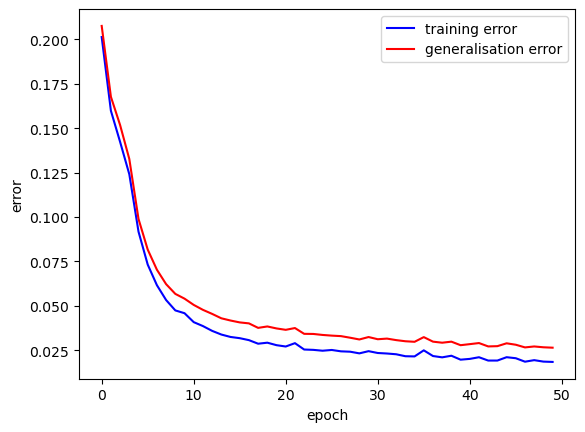

MLP geodesic test error angle:9.767447471618652
MLP geodesic val error angle :9.253777503967285


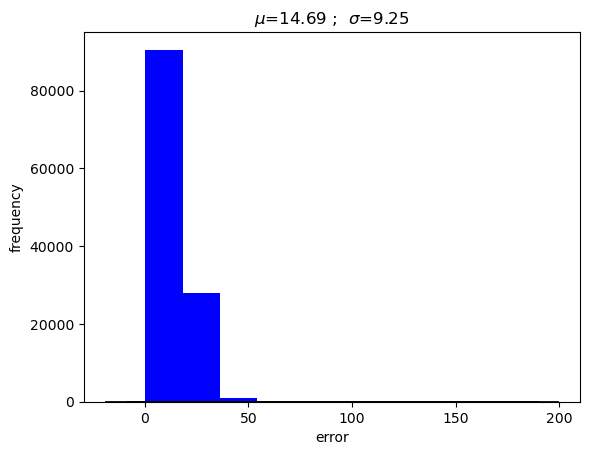

In [98]:
%matplotlib inline
torch.manual_seed(27)
#Define the model
good_parameters = [[126, 96, 72, 65, 56], nn.ReLU(), 0.0001, 500, 50]
hidden_layer_sizes, activation_fn, lr, batch_size, n_epoch  = good_parameters

model = create_model(input_size, output_size, hidden_layer_sizes, activation=activation_fn, device=device)

#loss function and optimizer
loss_fn = my_new_loss
optimizer = optim.Adam(model.parameters(), lr=lr)

batch_start = torch.arange(0, len(X_train), batch_size)

#Hold the best model
chosen_epoch = 0
best_error = np.inf   #init to infinity
best_weights = None
training_error_list = []
generalisation_error_list = []
n_epochs = 50

for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            #take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            #forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            #update weights
            optimizer.step()
            #print progress
            bar.set_postfix(error=float(loss))
    #evaluate accuracy at end of each epoch
    model.eval()
    #training error
    training_error_list.append(float(loss_fn(model(X_train), y_train)))
    #generalisation error
    y_pred = model(X_test)
    generalisation_error = loss_fn(y_pred, y_test)
    generalisation_error = float(generalisation_error)
    generalisation_error_list.append(generalisation_error)
    if generalisation_error < best_error:
        best_error = generalisation_error
        best_weights = copy.deepcopy(model.state_dict())
        chosen_epoch = epoch


print("******************************************")
#restore model and return best accuracy
model.load_state_dict(best_weights)

y_train_pred    = model(X_train)
train_error     = loss_fn(y_train_pred, y_train)

y_test_pred = model(X_test)
test_error  = loss_fn(y_test_pred, y_test)

y_pred = model(X_val)
val_error   = loss_fn(y_val, y_pred)

print(f"chosen epoch: {chosen_epoch}")
print(f"train Error     : {train_error}")
print(f"test Error      : {test_error}")
print(f"validation Error: {val_error}")

plt.close()

plt.plot(training_error_list, c="blue", label="training error")
plt.plot(generalisation_error_list, c="red", label="generalisation error")
plt.legend()
plt.xlabel("epoch"), plt.ylabel("error")
plt.show()

print(f"MLP geodesic test error angle:{geodesic_error(y_test_pred, y_test)}")
print(f"MLP geodesic val error angle :{geodesic_error(y_pred, y_val)}")

In [99]:
print(f"TRIAD mean geodesic test error: {mean_triad_angle_error(df_test)}°")
print(f"TRIAD mean geodesic val error:  {mean_triad_angle_error(df_val)}°")

TRIAD mean geodesic test error: 8.271135585170999°
TRIAD mean geodesic val error:  8.26723195584429°


In [100]:
print(f"TRIAD std geodesic test error: {triad_angle_error_std(df_test)}°")
print(f"TRIAD std geodesic val error:  {triad_angle_error_std(df_val)}°")

TRIAD std geodesic test error: 6.113613679553405°
TRIAD std geodesic val error:  6.125445250414322°


### MLP-aided TRIAD

In [101]:
"""Defining the input features and the output"""
X_columns = ['x', 'z', 'mag_x', 'mag_y', 'mag_z', 'B_I_x', 'B_I_y', 'B_I_z',
             's_I_x', 's_I_y', 'n_I_x', 'n_I_y', 'n_I_z', 'CNT_px', 'CNT_mx', 'CNT_py',
             'CNT_my', 'CNT_pz', 'CNT_mz', 'OSR_px', 'OSR_mx', 'OSR_py', 'OSR_my', 'OSR_pz',
             'OSR_mz', 'P_px', 'P_mx', 'P_py', 'P_my', 'P_pz', 'P_mz', 'gyro_x', 'gyro_y', 'gyro_z']
Y_columns = ['q1', 'q2', 'q3', 'q4']

In [102]:
def Y_from_df(df):
    """
    Returns the nadir direction and magnetic field vectors
    """
    Y = np.zeros(shape=(len(df), 6))
    for i in range(len(df)):
        q = df.iloc[i]
        P_BODY_I = q_to_R(q)[0:3,0:3].transpose()

        n_I = np.matrix(df.iloc[i][['n_I_x', 'n_I_y', 'n_I_z']]).transpose()
        B_I = np.matrix(df.iloc[i][['B_I_x', 'B_I_y', 'B_I_z']]).transpose()

        n_BODY = P_BODY_I@n_I
        B_BODY = P_BODY_I@B_I

        n_BODY = np.array(n_BODY).squeeze()
        B_BODY = np.array(B_BODY).squeeze()

        #normalization
        n_BODY = n_BODY/np.linalg.norm(n_BODY)
        B_BODY = B_BODY/np.linalg.norm(B_BODY)

        row = np.concatenate([n_BODY, B_BODY])

        Y[i,:] = row
    return Y

In [103]:
"""shuffling the datasets, scaling them and converting them to tensors"""
X_train_raw = df_train[X_columns].values
X_test_raw  = df_test[X_columns].values
X_val_raw   = df_val[X_columns].values

y_train_np = Y_from_df(df_train)
y_test_np  = Y_from_df(df_test)
y_val_np   = Y_from_df(df_val)

#Standardizing data
scaler  = StandardScaler()
scaler.fit(X_train_raw)

X_train_np = scaler.transform(X_train_raw)
X_test_np  = scaler.transform(X_test_raw)
X_val_np   = scaler.transform(X_val_raw)

#Shuffling the training data
seed = 64

np.random.seed(seed)
np.random.shuffle(X_train_np)
np.random.shuffle(X_test_np)
np.random.shuffle(X_val_np)

np.random.seed(seed)
np.random.shuffle(y_train_np)
np.random.shuffle(y_test_np)
np.random.shuffle(y_val_np)

#Convert to 2D PyTorch tensors and send them to the GPU if compatible
X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_np, dtype=torch.float32).to(device)
X_test  = torch.tensor(X_test_np, dtype=torch.float32).to(device)
y_test  = torch.tensor(y_test_np, dtype=torch.float32).to(device)
X_val   = torch.tensor(X_val_np, dtype=torch.float32).to(device)
y_val   = torch.tensor(y_val_np, dtype=torch.float32).to(device)

input_size  = X_train.shape[1]
output_size = y_train.shape[1]

Epoch 49: 100%|██████████| 60/60 [00:00<00:00, 291.27batch/s, error=2.3e-6] 


******************************************
chosen epoch    : 0
train Error     : 0.002550395205616951
test Error      : 0.05648244544863701
validation Error: 0.05873296409845352


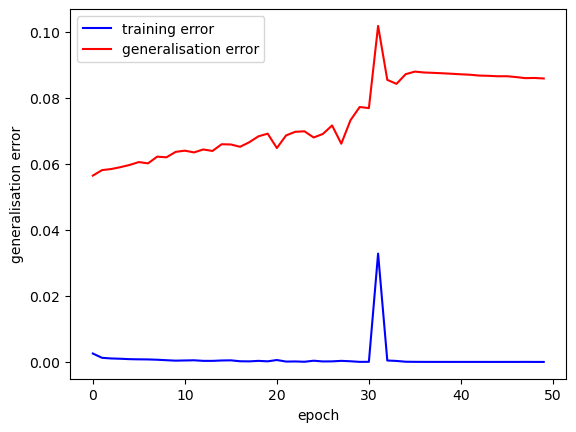

In [104]:
torch.manual_seed(76)
#Define the model

hidden_layer_sizes, activation_fn, lr, batch_size, n_epoch  = [[256, 128, 64, 32, 16], nn.ReLU(), 0.01, 10000, 75]

model = create_model(input_size, output_size, hidden_layer_sizes, activation=activation_fn, device=device)

#loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

batch_start = torch.arange(0, len(X_train), batch_size)

#Hold the best model
chosen_epoch = 0
best_error = np.inf   #init to infinity
best_weights = None
training_error_list = []
generalisation_error_list = []

for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            #take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            #forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            #update weights
            optimizer.step()
            #print progress
            bar.set_postfix(error=float(loss))
    #evaluate accuracy at end of each epoch
    model.eval()
    #training error
    training_error_list.append(float(loss_fn(model(X_train), y_train)))
    #generalisation error
    y_pred = model(X_test)
    generalisation_error = loss_fn(y_pred, y_test)
    generalisation_error = float(generalisation_error)
    generalisation_error_list.append(generalisation_error)
    if generalisation_error < best_error:
        best_error = generalisation_error
        best_weights = copy.deepcopy(model.state_dict())
        chosen_epoch = epoch


print("******************************************")
#restore model and return best accuracy
model.load_state_dict(best_weights)

y_train_pred    = model(X_train)
train_error     = loss_fn(y_train_pred, y_train)

y_test_pred = model(X_test)
test_error  = loss_fn(y_test_pred, y_test)

y_pred = model(X_val)
val_error   = loss_fn(y_pred, y_val)

print(f"chosen epoch    : {chosen_epoch}")
print(f"train Error     : {train_error}")
print(f"test Error      : {test_error}")
print(f"validation Error: {val_error}")

plt.plot(training_error_list, c="blue")
plt.plot(generalisation_error_list, c="red")
plt.legend(["training error", "generalisation error"])
plt.xlabel("epoch"), plt.ylabel("generalisation error")
plt.show()

In [105]:
y_pred = model(X_val)

nadir_pred   = y_pred[:, 0:3]
mag_pred     = y_pred[:, 3:6]

#normalization
nadir_pred  = nadir_pred/torch.sqrt(torch.sum(nadir_pred*nadir_pred, axis=1)).reshape((len(nadir_pred), 1)).expand(len(nadir_pred), 3)
mag_pred    = mag_pred/torch.sqrt(torch.sum(mag_pred*mag_pred, axis=1)).reshape((len(mag_pred), 1)).expand(len(mag_pred), 3)

nadir_val   = y_val[:, 0:3]
mag_val     = y_val[:, 3:6]

nadir_error_angle = torch.arccos(torch.sum(nadir_pred*nadir_val, axis=1)).cpu().detach().numpy()*180/np.pi
mag_error_angle   = torch.arccos(torch.sum(mag_pred*mag_val, axis=1)).cpu().detach().numpy()*180/np.pi

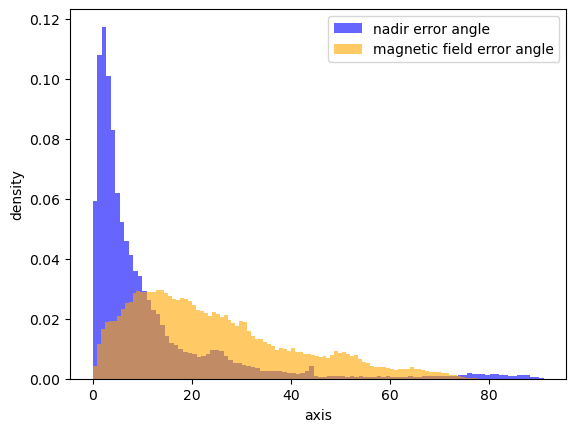

In [106]:
plt.hist(nadir_error_angle, bins=100, density=True, alpha=0.6, color="blue")
plt.hist(mag_error_angle, bins=100, density=True, alpha=0.6, color="orange")
plt.xlabel("axis")
plt.ylabel("density")  # Change "frequency" to "density" in the ylabel
plt.legend(["nadir error angle", "magnetic field error angle"])

In [107]:
#nan due to epsilon machine
np.where(np.isnan(nadir_error_angle)==True)
nadir_error_angle[np.where(np.isnan(nadir_error_angle)==True)] = 0
mag_error_angle[np.where(np.isnan(mag_error_angle)==True)] = 0

In [108]:
np.max(nadir_error_angle), np.max(mag_error_angle)

(90.99334, 79.89477)

In [109]:
print(f"Nadir angle mean          : {np.mean(nadir_error_angle)}°")
print(f"Nadir angle STD           : {np.std(nadir_error_angle)}°")

print(f"Magnetic field angle mean : {np.mean(mag_error_angle)}°")
print(f"Magnetic field angle STD  : {np.std(mag_error_angle)}°")

Nadir angle mean          : 11.479713439941406°
Nadir angle STD           : 15.587158203125°
Magnetic field angle mean : 24.283544540405273°
Magnetic field angle STD  : 16.35007667541504°


In [110]:
print(f"Nadir angle mediab          : {np.median(nadir_error_angle)}°")
print(f"Nadir angle STD             : {np.std(nadir_error_angle)}°")

Nadir angle mediab          : 5.7988691329956055°
Nadir angle STD             : 15.587158203125°
